<a href="https://colab.research.google.com/github/JoannaLe/cancer-detection/blob/master/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMS 4995 Final Project
Joanna Le (jl4624) \\
Ashley Koo (hk2827)

The aim of this project is to detect tumor cells from non-cancerous cells, and create a prototype of a classifier that gets as close to the 92.4% accuracy achievedy by the [paper](https://arxiv.org/abs/1703.02442) . 
It uses a portion of the CAMELYON16 dataset, found [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5). 

X = patches

Y = corresponding mask file (the mask shows the region of the slide that contain cancerous cells.)

In [1]:
# Download OpenSlide that reads whole-slide images
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (210 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [2]:
import os

# Open Google Cloud Drive
from google.colab import drive
drive.mount('/content/gdrive')

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Import dependencies 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import os


In [5]:
# Download an example slide (not yet the input x) and a tumor mask (y)
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  63.1M      0  0:00:08  0:00:08 --:--:-- 74.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  47.7M      0 --:--:-- --:--:-- --:--:-- 47.7M


In [6]:
# Use Open Slides to read the slide and mask
slide = open_slide(slide_path)
# Print the dimensions of the slide 
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s with width: %d, height: %d" % (tumor_mask_path,
                                                               tumor_mask.level_dimensions[0][0], 
                                                               tumor_mask.level_dimensions[0][1]))


# Look into the slide at different zoom levels 
print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]


Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif with width: 61440, height: 53760
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# Read a patch from the slide
# Returns a RGB array
def read_slide(slide, x, y, level, width, height, as_float=False):
    # read_region() API call 
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

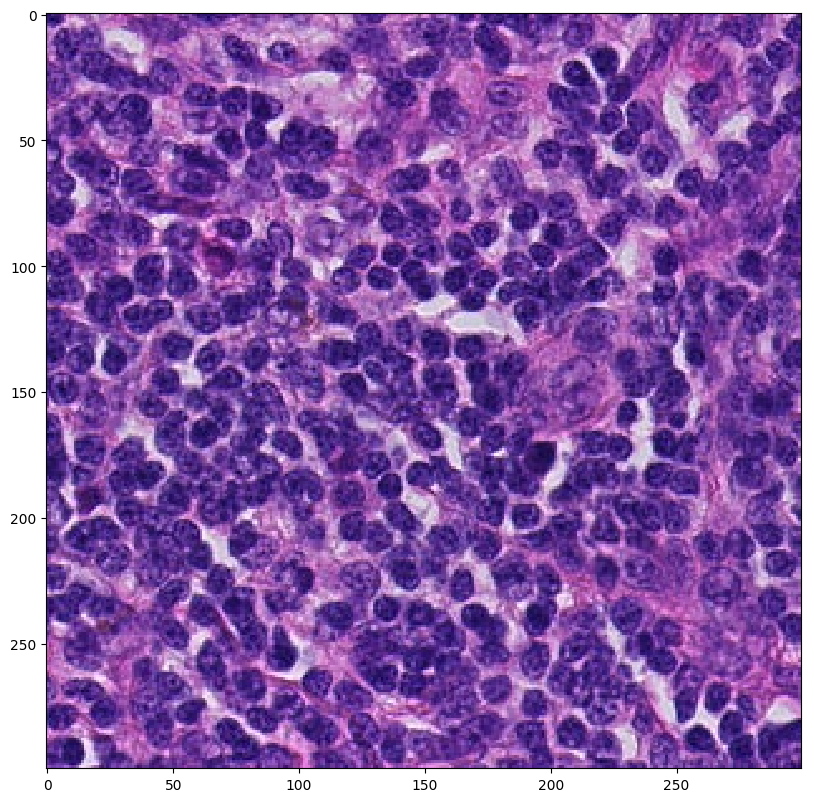

In [8]:
# Example: Reading entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
level = 5
slide_image = read_slide(slide, 
                         x=15000 * 2, 
                         y=15000 * 2, 
                         level=level, 
                         width=300, 
                         height=300)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

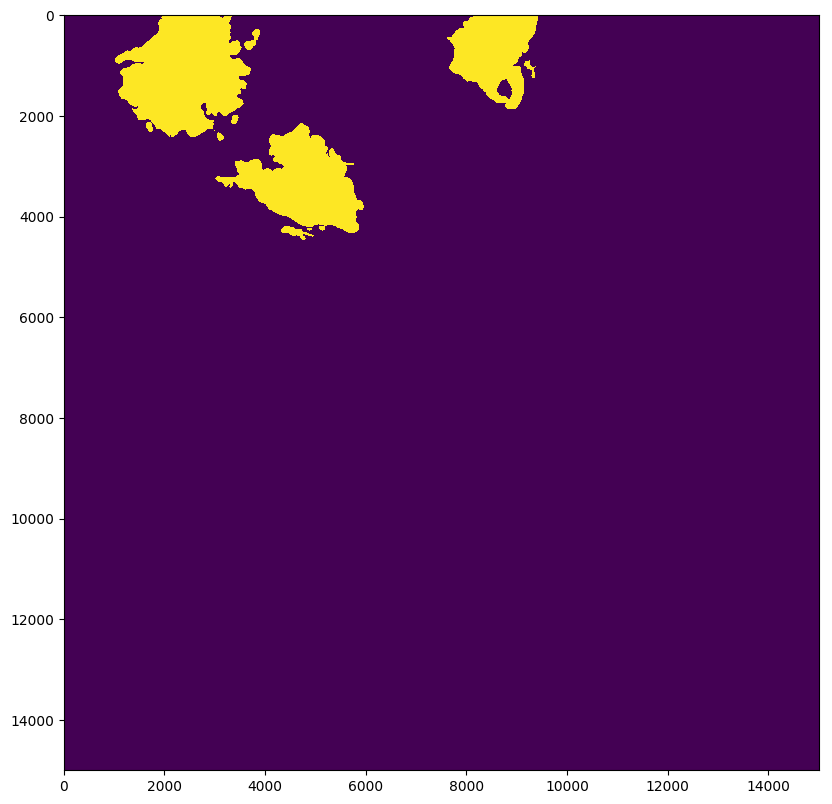

In [9]:
# Example: Reading entire mask at the same zoom level 5
mask_image = read_slide(tumor_mask, 
                         x=15000 * 2, 
                         y=15000 * 2, 
                         level=1, 
                         width=15000, 
                         height=15000)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

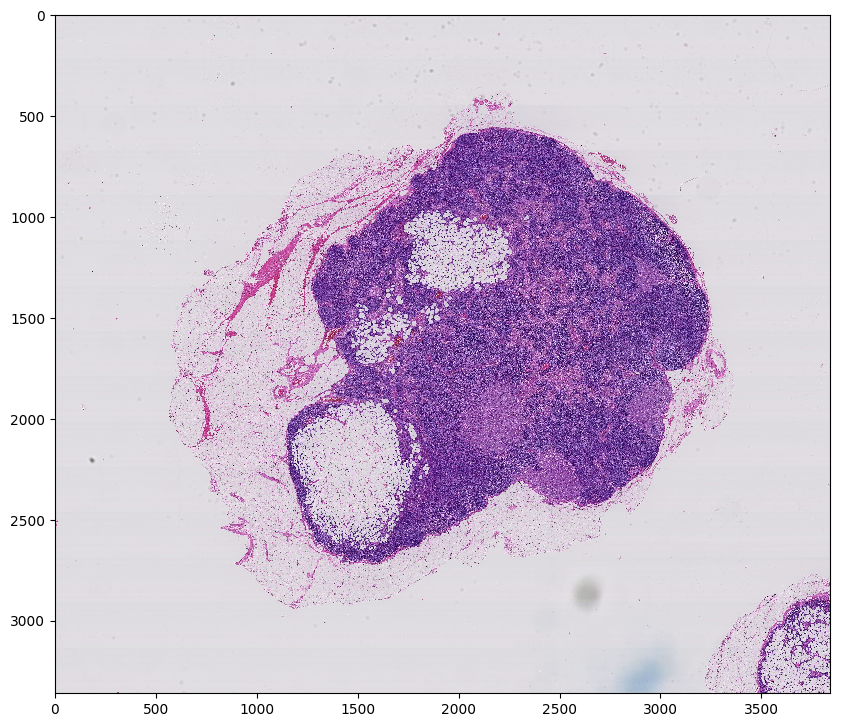

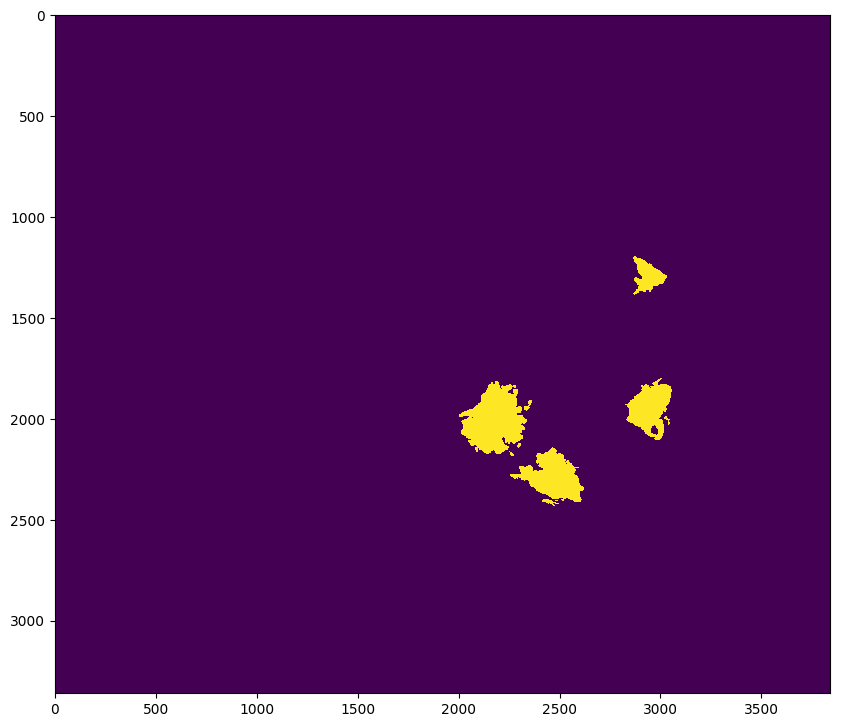

In [9]:
# Now working with zoom level 4

# Level 4, dimensions: (3840, 3360) downsample factor 16

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.
level = 4

slide_image = read_slide(slide, 
                         x=0 * 16, 
                         y=0 * 16, 
                         level=level, 
                         width=3840, 
                         height=3360)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
  
# Example: Reading entire mask at the same zoom level 5
mask_image = read_slide(tumor_mask, 
                         x=0 * 16, 
                         y=0 * 16, 
                         level=level, 
                         width=3840, 
                         height=3360)


# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)
  

8
51 44
(45, 52)
		row 2250
		column 5550


0.13756666666666667
		row 2250
		column 5700


0.23043333333333332
		row 2400
		column 5550


0.26284444444444444
		row 2400
		column 5700


0.5936888888888889
		row 2400
		column 5850


0.3877111111111111
		row 2550
		column 5550


0.18255555555555555
		row 2550
		column 5700


0.4515
		row 2550
		column 5850


0.32515555555555553
		row 3450
		column 4200


0.20915555555555557
		row 3450
		column 4350


0.1875888888888889
		row 3450
		column 5700


0.18795555555555554
		row 3450
		column 5850


0.25633333333333336
		row 3450
		column 6000


0.102
		row 3600
		column 4050


0.30864444444444444
		row 3600
		column 4200


0.6831222222222222
		row 3600
		column 4350


0.5729666666666666
		row 3600
		column 4500


0.21376666666666666
		row 3600
		column 5550


0.2662
		row 3600
		column 5700


0.6498555555555555
		row 3600
		column 5850


0.6512555555555556
		row 3600
		column 6000


0.2469222222222222
		row 3750
		column 3900


0.253911111111111

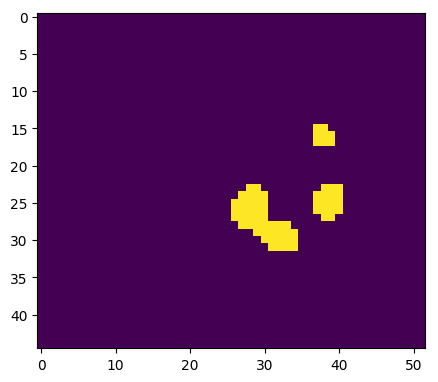

In [22]:
# What regions of cancer do we predict? 10% 
# Debugging padding 
level = 3

patch_x_dim = 300
patch_y_dim = 300
downsample = 2 ** level
print(downsample)

num_patch_x = slide.level_dimensions[level][0] // (patch_x_dim // 2)
num_patch_y = slide.level_dimensions[level][1] // (patch_y_dim // 2)
print(num_patch_x, num_patch_y) # 25, 22

masks = []
matrix = np.zeros((num_patch_y + 1, num_patch_x + 1), dtype=int)
print(matrix.shape)
# for every row 
for i in range(0, num_patch_y + 1):
  # span every cell 
  for j in range(0, num_patch_x + 1):
    mask_image = read_slide(tumor_mask, 
                             x=(0 + j * patch_x_dim // 2) * downsample, # 128 = downsample factor
                             y=(0 + i * patch_y_dim // 2) * downsample, 
                             level=level, 
                             width=patch_x_dim, 
                             height=patch_y_dim) # edge cases? 
    mask_image = mask_image[:,:,0] # RGB => 
    
    # count tumors in the patch
    count = 0 
    tumorcount = 0
    # every row 
    for row in mask_image: 
      for cell in row:
        if int(cell) == 1:
          count += 1
    perc = count / (300 * 300) # percentage wise
#     print(perc)
    if perc > 0.1:
      masks.append(1)
      print('\t\trow', i * patch_y_dim // 2)  
      print('\t\tcolumn', j * patch_x_dim // 2)
      print('\n')
      print(perc)
      matrix[i][j] = 1
      tumorcount = tumorcount + 1
    else:
      masks.append(0)
      matrix[i][j] = 0
print(matrix)
print(tumorcount)

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(matrix)


In [21]:
# Img 091, level5
level = 5

patch_x_dim = 300
patch_y_dim = 300
downsample = 2 ** level
print(downsample) # 16

num_patch_x = slide.level_dimensions[level][0] // (patch_x_dim // 2) 
num_patch_y = slide.level_dimensions[level][1] // (patch_y_dim // 2)
print(num_patch_x, num_patch_y) # 25, 22


slides = []
for i in range(0, num_patch_y + 1): # rows
  for j in range(0, num_patch_x + 1): # columns 
    width2 = 300
    height2 = 300
    need_padding = False # default 
    
    if j is num_patch_x: # edge of the row 
      width2 = slide.level_dimensions[level][0] % 150 # 300 / 2
      need_padding = True
    
    if i is num_patch_y:
      height2 = slide.level_dimensions[level][1] % 150 
      need_padding = True
    
    slide_image = read_slide(slide, 
                             x=(0 + j * 150) * downsample,
                             y=(0 + i * 150) * downsample, 
                             level=level, 
                             width=width2, 
                             height=height2) # edge cases 
    
#     Post-processing, edge cases   
    if i is num_patch_y or j is num_patch_x:
      temp_array = np.full((300, 300, 3), -1) # fill with -1's 
#       print(temp_array[50, 50, :])
#       print(slide_image.shape)
      for j in range(slide_image.shape[0]): # do not repeat indices 
        for k in range(slide_image.shape[1]):
          for l in range(slide_image.shape[2]):
            temp_array[j, k, l] = slide_image[j, k, l]
            
      slide_image = temp_array
#       print(slide_image[50, 50, :])
#       print(slide_image[280, 280, :]) # -1's

    
    slides.append(slide_image)
#     print(slides)

# Add to local gdrive  
img = "091" # imp
patch_dir = "gdrive/My Drive/cancer-detection/patch-zoom-" + str(level)
print(patch_dir)
for i in range(len(slides)):
  patch_name = img + "-patch-" + str(i)
#   print(patch_name)
  data = slides[i]
  print(data)
  np.savetxt(patch_name, data, fmt='%i')    
  !mv "$patch_name" "$patch_dir"
  
  
  





32
12 11
gdrive/My Drive/cancer-detection/patch-zoom-5
[[[220 218 223]
  [220 218 223]
  [220 218 223]
  ...
  [221 219 224]
  [221 219 224]
  [221 219 224]]

 [[220 218 223]
  [220 218 223]
  [220 218 223]
  ...
  [221 219 224]
  [221 219 224]
  [221 219 224]]

 [[220 218 223]
  [220 218 223]
  [220 218 223]
  ...
  [221 219 224]
  [221 219 224]
  [221 219 224]]

 ...

 [[221 219 224]
  [221 219 224]
  [222 220 225]
  ...
  [222 220 225]
  [222 220 225]
  [222 220 225]]

 [[221 219 224]
  [221 219 224]
  [222 220 225]
  ...
  [222 220 225]
  [222 220 225]
  [222 220 225]]

 [[221 219 224]
  [221 219 224]
  [222 220 225]
  ...
  [222 220 225]
  [222 220 225]
  [222 220 225]]]
[[[221 219 224]
  [221 219 224]
  [221 219 224]
  ...
  [219 217 222]
  [220 215 222]
  [220 215 222]]

 [[221 219 224]
  [221 219 224]
  [221 219 224]
  ...
  [220 218 223]
  [222 217 224]
  [221 216 223]]

 [[221 219 224]
  [221 219 224]
  [221 219 224]
  ...
  [221 219 224]
  [223 218 225]
  [222 217 224]]

 ..

(23, 26)
gdrive/My Drive/cancer-detection/mask-zoom-4


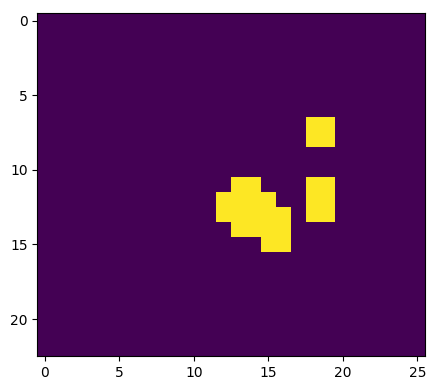

In [19]:
masks = []
matrix = np.zeros((num_patch_y + 1, num_patch_x + 1), dtype=int)
print(matrix.shape)
# for every row 
for i in range(0, num_patch_y + 1):
  # span every cell 
  for j in range(0, num_patch_x + 1):
    width2 = 300
    height2 = 300
    checkin = False
    if i is num_patch_y:
      checkin = True
      width2 = slide.level_dimensions[level][0] % 150 
    if j is num_patch_x:
      height2 = slide.level_dimensions[level][1] % 150 
      checkin = True


    mask_image = read_slide(tumor_mask, 
                             x=(0 + j * 150) * downsample, # 128 = downsample factor
                             y=(0 + i * 150) * downsample, 
                             level=level, 
                             width=width2, # edge 
                             height=height2) 
    mask_image = mask_image[:,:,0] # RGB => 
#     if checkin
#       print(mask_image.shape) # debug: should be not 300, 300
      
    # count tumors in the patch
    count = 0 
    # every row 
    for row in mask_image: 
      for cell in row:
        if int(cell) == 1:
          count += 1
    perc = count / (300 * 300) # percentage wise
#     print(perc)
    if perc > 0.1:
      masks.append(1)
      matrix[i][j] = 1
    else:
      masks.append(0)
      matrix[i][j] = 0

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(matrix)

# Add to local gdrive
mask_dir = "gdrive/My Drive/cancer-detection/mask-zoom-" + str(level)
print(mask_dir)
for i in range(len(masks)):
  mask_name = img + "-mask-" + str(i)
  with open(mask_name, 'w') as file:
    data = masks[i]
    file.write(str(data))
  
  !mv "$mask_name" "$mask_dir"

In [87]:
patch_dir = "gdrive/My Drive/cancer-detection/mask-zoom-" + str(level)
print(os.path.isdir(patch_dir))


True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


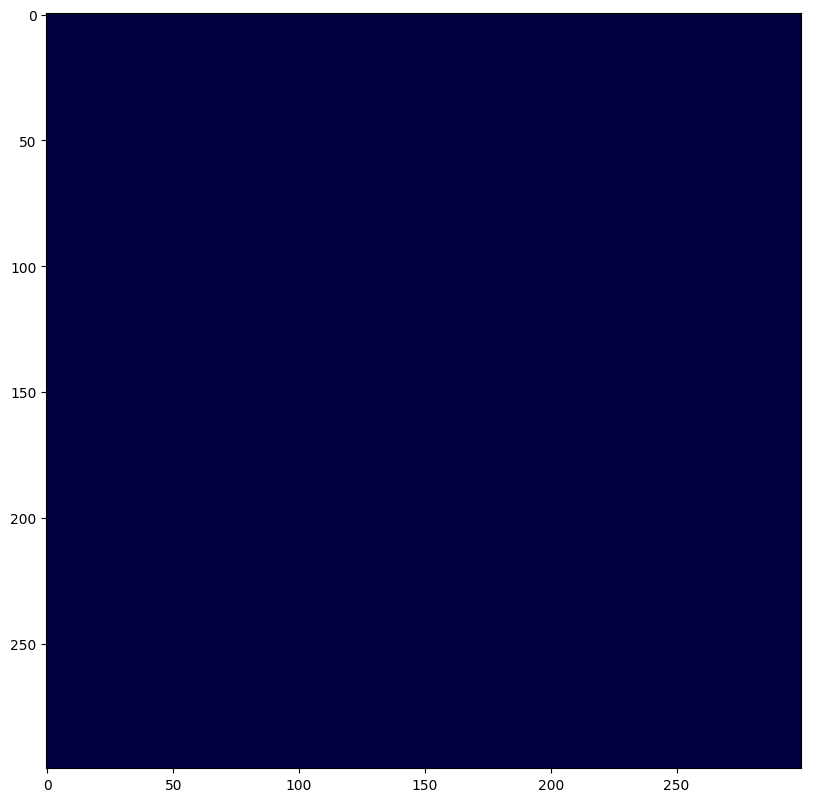

In [12]:
# Overlay the two. The mask shows the region of the slide that contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

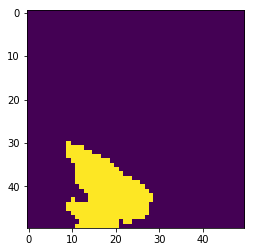

In [13]:
# Sliding window technique 

# Example: extract a patch/region from the L7 downsampled image

# How did they get the x, y coordinates?
# Note: first multiply x, y coordinates by downsample factor
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

90000 tissue_pixels pixels (100.0 percent of the image)


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


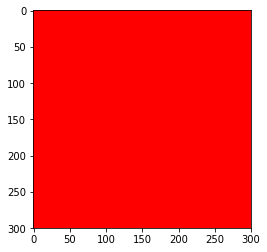

In [14]:
# Improve efficiency by ignoring non-tissue areas of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
# Step 1 
# Break up slide at level 7 into 4 patches

# num_patch = 4

# slides = []
# slide_image = read_slide(slide, 
#                          x=0 * 128, 
#                          y=0 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)

# slides.append(slide_image)
# slide_image = read_slide(slide, 
#                          x=240 * 128, 
#                          y=0 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# slides.append(slide_image)
# slide_image = read_slide(slide, 
#                          x=0 * 128, 
#                          y=210 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# slides.append(slide_image)

# slide_image = read_slide(slide, 
#                          x=240 * 128, 
#                          y=210 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# slides.append(slide_image)
# print(slide_image)


# plt.figure(figsize=(5,5), dpi=100)
# plt.imshow(slide_image_1)
# plt.imshow(slide_image_2)
# plt.imshow(slide_image_3)
# plt.imshow(slide_image_4)

# # Add to local gdrive  
# root_path = 'gdrive/My Drive/cancer-detection'  
# for i in range(0, 4):
#   patch_dir = root_path + "/patch"
#   patch_name = "patch_" + str(i)
#   with open(patch_name, 'w') as file:
#     data = slides[i]
#     file.write(str(data))
    
#   !mv "$patch_name" "$patch_dir"

  
# # Add masks
# masks = []
# mask_image = read_slide(tumor_mask, 
#                          x=0 * 128, 
#                          y=0 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)

# masks.append(mask_image)
# mask_image = read_slide(tumor_mask, 
#                          x=240 * 128, 
#                          y=0 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# masks.append(mask_image)
# mask_image = read_slide(tumor_mask, 
#                          x=0 * 128, 
#                          y=210 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# masks.append(mask_image)

# mask_image = read_slide(tumor_mask, 
#                          x=240 * 128, 
#                          y=210 * 128, 
#                          level=7, 
#                          width=slide.level_dimensions[7][0]//2, 
#                          height=slide.level_dimensions[7][1]//2)
# masks.append(mask_image)
# print(mask_image)

# # Add to local gdrive  
# for i in range(0, 4):
#   mask_dir = root_path + "/mask"
#   mask_name = "mask_" + str(i)
#   with open(mask_name, 'w') as file:
#     data = masks[i]
#     file.write(str(data))
#   !mv "$mask_name" "$mask_dir"


In [0]:
# # Step 2
# # Break up slide at level 7 into patches of dimensions 100 x 100
# level = 7
# patch_x_dim = 300
# patch_y_dim = 300

# width=slide.level_dimensions[level][0]//patch_x_dim
# height=slide.level_dimensions[level][1]//patch_y_dim
# print(width, height)
# # width = 480 // 300 = 1
# # height = 420 // 300 = 1

# for i in range(0, height + 1):
#   for j in range(0, width + 1):
#     if i is height - 1:
#       height = slide.level_dimensions[level][1] % patch_y_dim
#     if j is width - 1: 
#       width = slide.level_dimensions[level][0] % patch_x_dim
#     slide_image = read_slide(slide, 
#                              x=(0 + j * patch_x_dim) * 128, 
#                              y=(0 + i * patch_y_dim) * 128, 
#                              level=7, 
#                              width=patch_x_dim, 
#                              height=patch_y_dim) # Padding 
#     slides.append(slide_image)


# # slides = []
# # slide_image = read_slide(slide, 
# #                          x=0 * 128, 
# #                          y=0 * 128, 
# #                          level=7, 
# #                          width=slide.level_dimensions[7][0]//2, 
# #                          height=slide.level_dimensions[7][1]//2)

# # slides.append(slide_image)
# # slide_image = read_slide(slide, 
# #                          x=240 * 128, 
# #                          y=0 * 128, 
# #                          level=7, 
# #                          width=slide.level_dimensions[7][0]//2, 
# #                          height=slide.level_dimensions[7][1]//2)
# # slides.append(slide_image)
# # slide_image = read_slide(slide, 
# #                          x=0 * 128, 
# #                          y=210 * 128, 
# #                          level=7, 
# #                          width=slide.level_dimensions[7][0]//2, 
# #                          height=slide.level_dimensions[7][1]//2)
# # slides.append(slide_image)

# # slide_image = read_slide(slide, 
# #                          x=240 * 128, 
# #                          y=210 * 128, 
# #                          level=7, 
# #                          width=slide.level_dimensions[7][0]//2, 
# #                          height=slide.level_dimensions[7][1]//2)
# # slides.append(slide_image)
# # print(slide_image)


# plt.figure(figsize=(5,5), dpi=100)
# plt.imshow(slide_image_1)
# plt.imshow(slide_image_2)
# plt.imshow(slide_image_3)
# plt.imshow(slide_image_4)

# # Add to disk  
# # import os
# # patch_repo = '/patch_repo'
# # if not os.path.exists(patch_repo): 
# #   os.mkdir(patch_repo)

# # patch_dir = os.path.join('/content', patch_repo) # necc?


# # Add to local gdrive  
# for i in range(0, 4):
#   patch_dir = "gdrive/My Drive/cancer-detection" # FIX THIS - doesn't work with subdirectory 
#   patch_name = "patch_" + str(i)
#   with open(patch_name, 'w') as file:
#     data = slides[i]
#     file.write(str(data)) 
    
#   !mv "$patch_name" "$patch_dir"

# # Break up Y at level 7 into patches of dimensions 100 x 100
# level = 7
# patch_x_dim = 100
# patch_y_dim = 100

# width=slide.level_dimensions[level][0]//patch_x_dim
# height=slide.level_dimensions[level][1]//patch_y_dim
# print(width, height)
# # width = 480 // 7 = 6
# # height = 420 // 7 = 6

# masks = []
# for i in range(0, height):
#   for j in range(0, width):
#     if i is height - 1:
#       height = slide.level_dimensions[level][1] % patch_y_dim
#     if j is width - 1: 
#       width = slide.level_dimensions[level][0] % patch_x_dim
#     tumor_image = read_slide(tumor_mask, 
#                              x=(0 + j * patch_x_dim) * 128, 
#                              y=(0 + i * patch_y_dim) * 128, 
#                              level=7, 
#                              width=width, 
#                              height=height)
#     masks.append(tumor_image)

    
# # Add to local gdrive  
# for i in range(0, 4):
#   mask_dir = "gdrive/My Drive/cancer-detection"
#   mask_name = "mask_" + str(i)
#   with open(mask_name, 'w') as file:
#     data = slides[i]
#     file.write(str(data))
    
#   !mv "$mask_name" "$mask_dir"


In [15]:
# Step 3
# Generate Overlapping Patches & Corresponding Masks at Level 6 

# Verify the Patches and Masks worked ** Create Heapmap 
level = 6

patch_x_dim = 300
patch_y_dim = 300

num_patch_x = slide.level_dimensions[level][0] // (patch_x_dim // 2)
num_patch_y = slide.level_dimensions[level][1] // (patch_y_dim // 2)
print(num_patch_x, num_patch_y) # expect 960 // 150 = 6 => 7 patches
                                # expect 840 // 150 = 5 => 6 patches

slides = []
for i in range(0, num_patch_y + 1): 
  for j in range(0, num_patch_x + 1):
    width = patch_x_dim
    height = patch_y_dim
    need_padding = False
    if i is num_patch_y: # height for edge case 
      height = slide.level_dimensions[level][1] % patch_y_dim 
      print(height)
      need_padding = True
    if j is num_patch_x: # width for edge case
      width = slide.level_dimensions[level][0] % patch_x_dim
      need_padding = True
    slide_image = read_slide(slide, 
                             x=(0 + j * patch_x_dim // 2) * 64, # 128 = downsample factor
                             y=(0 + i * patch_y_dim // 2) * 64, 
                             level=level, 
                             width=width, 
                             height=height) # edge cases 
    # Take care of edge cases  
    if need_padding: 
      # create numpy array of dimension 300 * 300 * 3
      temp_array = np.full((300, 300, 3), -1)
      # transfer over valid values
      i = 0 
      # row, width
#       print(len(slide_image))
#       print(len(slide_image[0]))
      for row in slide_image:
        j = 0 
        for cell in row:
          temp_array[i][j] = cell
          j = j + 1
#           print('j={}'.format(j))
        i = i + 1
#         print('i={}'.format(i))
      slide_image = temp_array
  
    slides.append(slide_image)


# Add to local gdrive  
# ADD LOGIC for MULTIPLE slides later 
for i in range(len(slides)):
  patch_dir = "gdrive/My Drive/cancer-detection/patch"
  patch_name = "patch_" + str(i)
  with open(patch_name, 'w') as file:
    data = slides[i]
    file.write(str(data))
    
  !mv "$patch_name" "$patch_dir"

# Break up masks at level 6 into patches of dimensions 100 x 100
masks = []
# If more than 10% of the region contains cancerous cells 
print(num_patch_y, num_patch_x)
for i in range(0, num_patch_y + 1):
  for j in range(0, num_patch_x + 1):
    mask_image = read_slide(tumor_mask, 
                             x=(0 + j * patch_x_dim // 2) * 64, # 128 = downsample factor
                             y=(0 + i * patch_y_dim // 2) * 64, 
                             level=level, 
                             width=patch_x_dim, 
                             height=patch_y_dim) # edge cases 
    mask_image = mask_image[:,:,0]

    count = 0 
    for row in mask_image: 
      for cell in row:
        if int(cell) == 1:
          count += 1
    perc = count / (300 * 300)
    print(perc)
    if perc > 0.1:
      masks.append(1)
      print('x', j * patch_x_dim // 2)
      print('y', i * patch_x_dim // 2) 
    else:
      masks.append(0)

# Add to local gdrive  
for i in range(len(masks)):
  mask_dir = "gdrive/My Drive/cancer-detection/mask"
  mask_name = "mask_" + str(i)
  with open(mask_name, 'w') as file:
    data = masks[i]
    file.write(str(data))

  !mv "$mask_name" "$mask_dir"


6 5
240
5 6
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.010555555555555556
0.011533333333333333
0.0009777777777777777
0.0
0.0
0.0
0.0608
0.12134444444444445
x 450
y 300
0.0675111111111111
0.006966666666666667
0.0
0.0
0.0
0.0608
0.11233333333333333
x 450
y 450
0.057522222222222225
0.005988888888888889
0.0
0.0
0.0
0.0
0.0015444444444444444
0.0015444444444444444
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


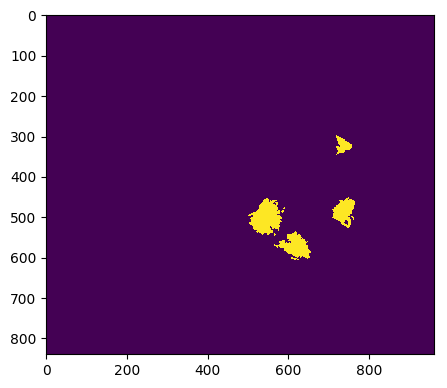

In [16]:
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=0 * 64, 
                        y=0 * 64, 
                        level=6, 
                        width=slide.level_dimensions[6][0],
                        height=slide.level_dimensions[6][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 



plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

uint8
5472
0.0608


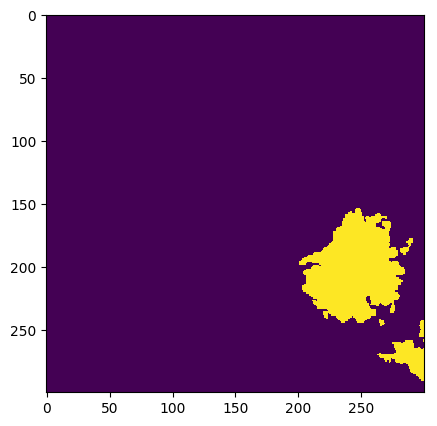

In [17]:
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=300 * 64, 
                        y=300 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 
count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

uint8
10110
0.11233333333333333


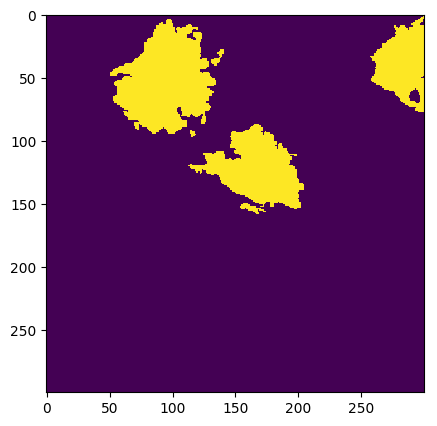

In [18]:
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=450 * 64, 
                        y=450 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 
count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

uint8
5177
0.057522222222222225


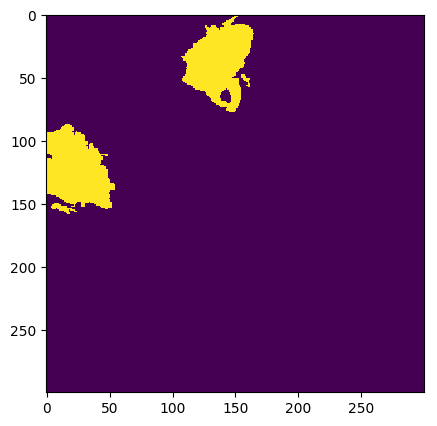

In [19]:
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=600 * 64, 
                        y=450 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 
count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

10921
0.12134444444444445


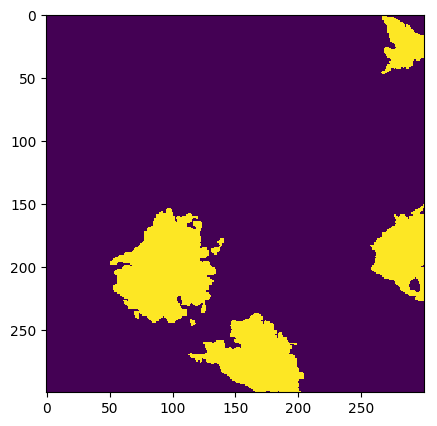

In [20]:
# Example: Reading a portion mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=450 * 64, 
                        y=300 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

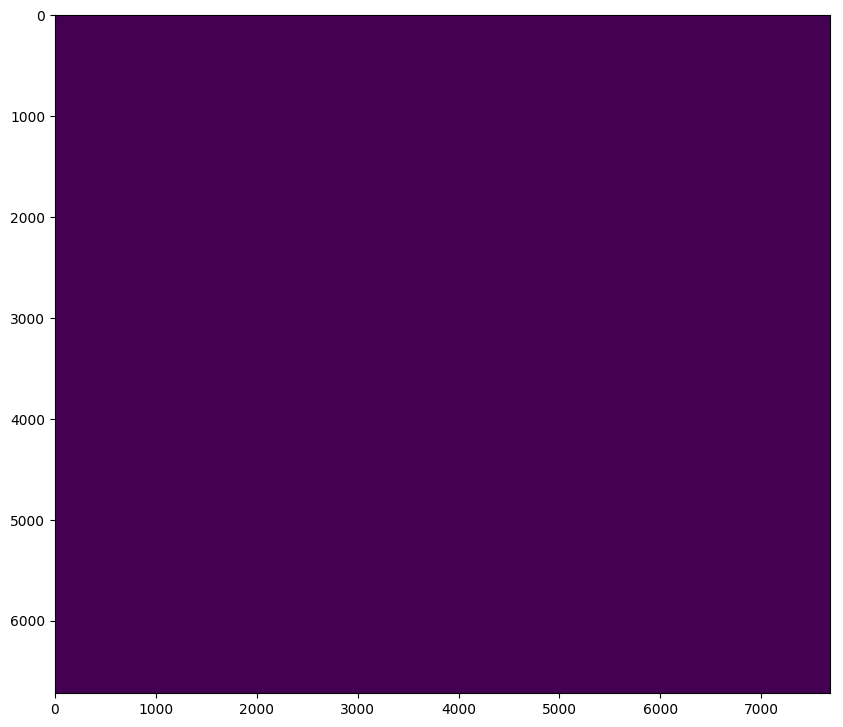

In [21]:
# Example: Reading an entire mask at the zoom level 3
mask_image = read_slide(tumor_mask, 
                        x=4000 * 128, 
                        y=4000 * 128, 
                        level=3, 
                        width=slide.level_dimensions[3][0],
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 



plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

uint8
68990
0.7665555555555555


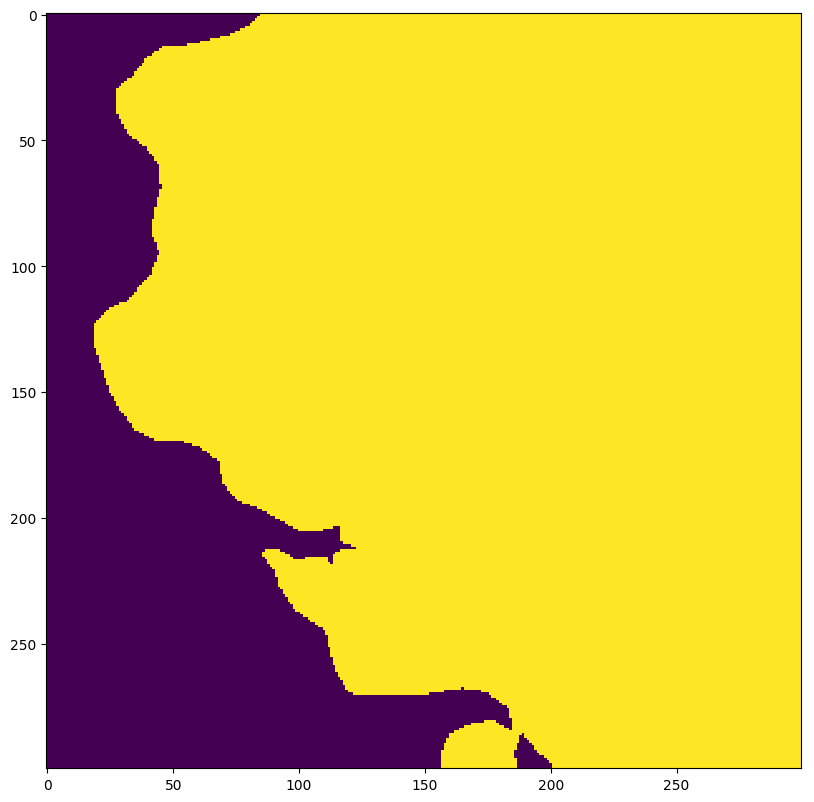

In [22]:
# Example: Reading an entire mask at the zoom level 3
mask_image = read_slide(tumor_mask, 
                        x=4000 * 8, 
                        y=4000 * 8, 
                        level=3, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [23]:
# a = 1
a = np.arange(2, dtype=np.uint8)
for elem in a:
  print(elem)
  if int(elem) == 1:
    print("yes")
# if a == 1:
#   print("yes")

0
1
yes


In [0]:
# Loop through folder and store somewhere else - NEXT STEP

uint8
11687
0.12985555555555556


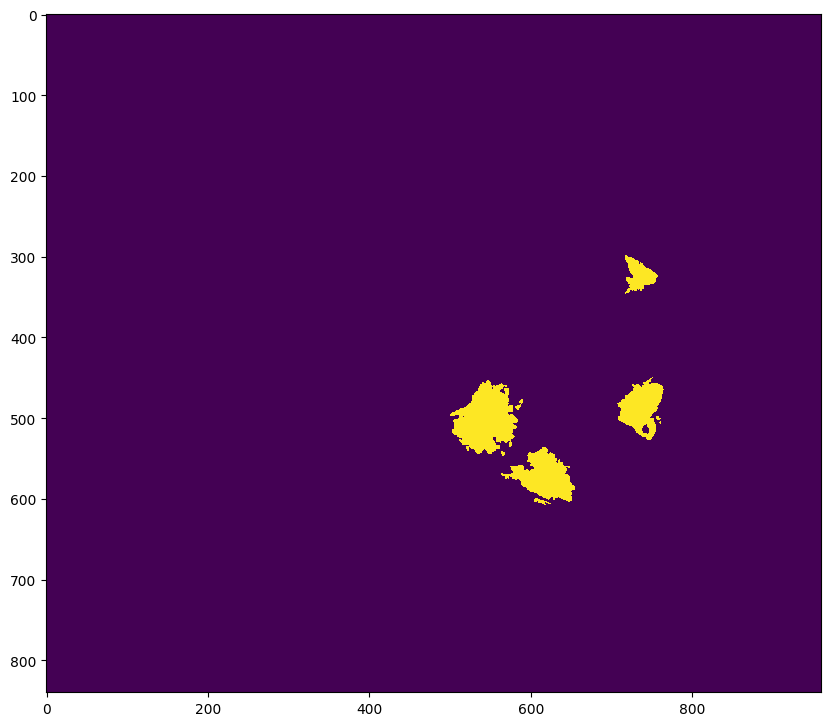

In [25]:
# Debugging patches worked
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=0 * 64, 
                        y=0 * 64, 
                        level=6, 
                        width=slide.level_dimensions[6][0],
                        height=slide.level_dimensions[6][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

uint8
6076
0.0675111111111111


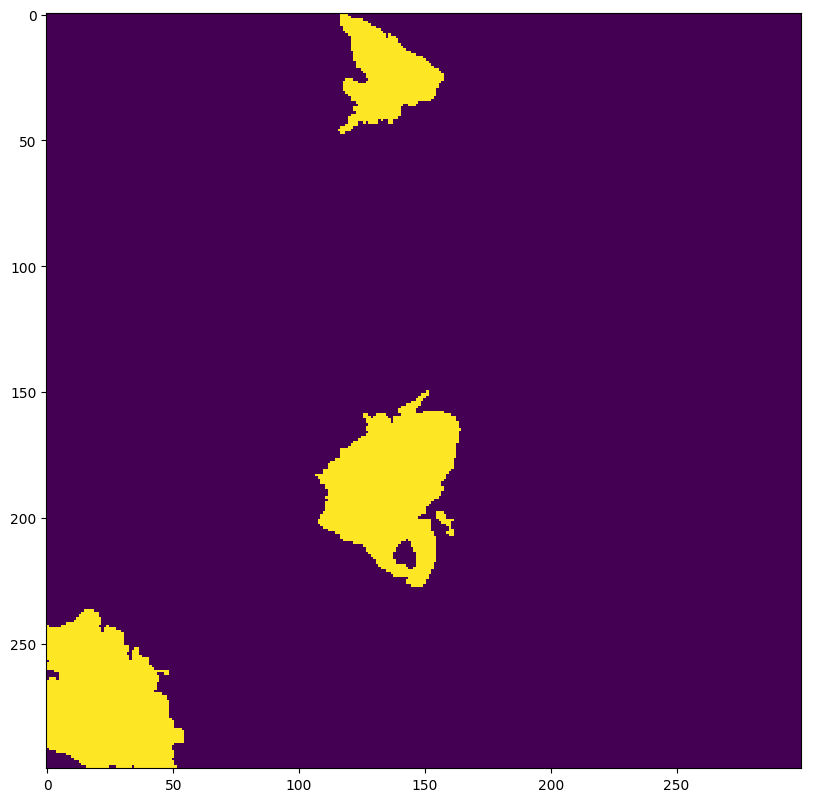

In [26]:
# Debugging patches worked
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=600 * 64, 
                        y=300 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

3 2
240
2 3
0.0
0.0
0.0
0.0
0.0
0.0608
Adding 1
x 300
y 300
0.0675111111111111
Adding 1
x 600
y 300
0.0
0.0
0.0
0.0015444444444444444
0.0


In [28]:
import os
mask_dir_test = "gdrive/My Drive/cancer-detection/mask_test"
patch_dir_test = "gdrive/My Drive/cancer-detection/patch_test"

matrix = np.zeros((3, 4), dtype=int) # 4 x 3 matrix, each bit 0 or 1 representing patch containing tumor or not 
count = 0 

os.chdir(original_dir)
print(os.getcwd())

# matrix[1][1] = 1
# matrix[2][3] = 1
# print(matrix)

for f1 in os.listdir(patch_dir_test): # returns a list containing the names of the entries in the directory given by path
  print("Patch  " + f1)
  arr = f1.split("_")
  num = arr[1] # get patch_num 

  for f2 in os.listdir(mask_dir_test):
    print("\tMask  " + f2)
    arr2 = f2.split("_")
    num2 = arr2[1]
    
    if arr2[0] == "mask": 
      if num == num2:
        f2 = os.path.join(mask_dir_test, f2)
        tumorFile = open(f2, "r")
        content = tumorFile.read()
        print((int)(content))
        matrix[ count//4 ][ count%4 ] = (int)(content)
        count = count + 1
print(matrix)
#     if num == num2:
#       print("Check the patch_test, mask_test")
    
             

NameError: ignored

In [0]:
# Verify overlapping worked -- maybe overdoing it? 
import os
mask_dir_test = "gdrive/My Drive/cancer-detection/mask"
patch_dir_test = "gdrive/My Drive/cancer-detection/patch"

matrix = np.zeros((6, 7), dtype=int) # 4 x 3 matrix, each bit 0 or 1 representing patch containing tumor or not 
count = 0 
print(matrix)
os.chdir(original_dir)
print(os.getcwd())

# matrix[1][1] = 1
# matrix[2][3] = 1
# print(matrix)

for f1 in os.listdir(patch_dir_test): # returns a list containing the names of the entries in the directory given by path
  arr = f1.split("_")
  num = arr[1] # get patch_num 

  for f2 in os.listdir(mask_dir_test):
    arr2 = f2.split("_")
    num2 = arr2[1]
    
    if arr2[0] == "mask": 
      if num == num2:
        f2 = os.path.join(mask_dir_test, f2)
        tumorFile = open(f2, "r")
        content = tumorFile.read()
        print((int)(content))
        if (int)(content) == 1:
          print(count//7, count%7)
        matrix[ count//7 ][ count%7 ] = (int)(content)
        count = count + 1
print(matrix)
#     if num == num2:
#       print("Check the patch_test, mask_test")
    
             

In [0]:
# Debugging patches worked
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=0 + 150 * 3 * 64, 
                        y=0 + 150 * 2 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [0]:
# Debugging patches worked
# Example: Reading an entire mask at the zoom level 6
mask_image = read_slide(tumor_mask, 
                        x=0 + 150 * 3 * 64, 
                        y=0 + 150 * 3 * 64, 
                        level=6, 
                        width=300,
                        height=300)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# Figure out how much of the image say they are cancerous, percentage wise 
# Expect to divide by 3, and half of that amount would be enough to classify a patch as cancerous I think. 

count = 0 
print(mask_image.dtype)
for row in mask_image: 
  for cell in row:
    if int(cell) == 1:
      count += 1
print(count)
print(count / (300 * 300))
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [0]:
# Get another image (from gdrive this time)
import os 

# Slides folder  
data_path = "gdrive/My Drive/cancer-detection_data/slides"

# Another image
slide_path = "gdrive/My Drive/cancer-detection_data/slides/tumor_001.tif"
mask_path = "gdrive/My Drive/cancer-detection_data/slides/tumor_001_mask.tif"

slide = open_slide(slide_path)
mask = open_slide(mask_path)




In [93]:
import os
# Classifier  
x_path = "gdrive/My Drive/cancer-detection/patch-zoom-4"


print(os.listdir(x_path))

os.getcwd()
for file in os.listdir(x_path):
  path_file = os.path.join(x_path, file)
  print(path_file)
  content = open(path_file, "r")
  print(str(content))
  

['091-patch-0', '091-patch-1', '091-patch-2', '091-patch-3', '091-patch-4', '091-patch-5', '091-patch-6', '091-patch-7', '091-patch-8', '091-patch-9', '091-patch-10', '091-patch-11', '091-patch-12', '091-patch-13', '091-patch-14', '091-patch-15', '091-patch-16', '091-patch-17', '091-patch-18', '091-patch-19', '091-patch-20', '091-patch-21', '091-patch-22', '091-patch-23', '091-patch-24', '091-patch-25', '091-patch-26', '091-patch-27', '091-patch-28', '091-patch-29', '091-patch-30', '091-patch-31', '091-patch-32', '091-patch-33', '091-patch-34', '091-patch-35', '091-patch-36', '091-patch-37', '091-patch-38', '091-patch-39', '091-patch-40', '091-patch-41', '091-patch-42', '091-patch-43', '091-patch-44', '091-patch-45', '091-patch-46', '091-patch-47', '091-patch-48', '091-patch-49', '091-patch-50', '091-patch-51', '091-patch-52', '091-patch-53', '091-patch-54', '091-patch-55', '091-patch-56', '091-patch-57', '091-patch-58', '091-patch-59', '091-patch-60', '091-patch-61', '091-patch-62', '

In [0]:
slide_path = 'tumor_001.tif'
tumor_mask_path = 'tumor_001_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [0]:
# Generate patches for 4 levels!
